# Insurance Charge - Linear Regression

In this Linear Regression model, we will learn about feature encoding and transformation for the skewed data with numpy.

## Import Package

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Fetch Dataset

In [3]:
url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
df = pd.read_csv(url)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
df["region"].value_counts()

,count
region,
southeast,364
southwest,325
northwest,325
northeast,324


In [8]:
df["smoker"].value_counts()

,count
smoker,
no,1064
yes,274


## Visualise Feature

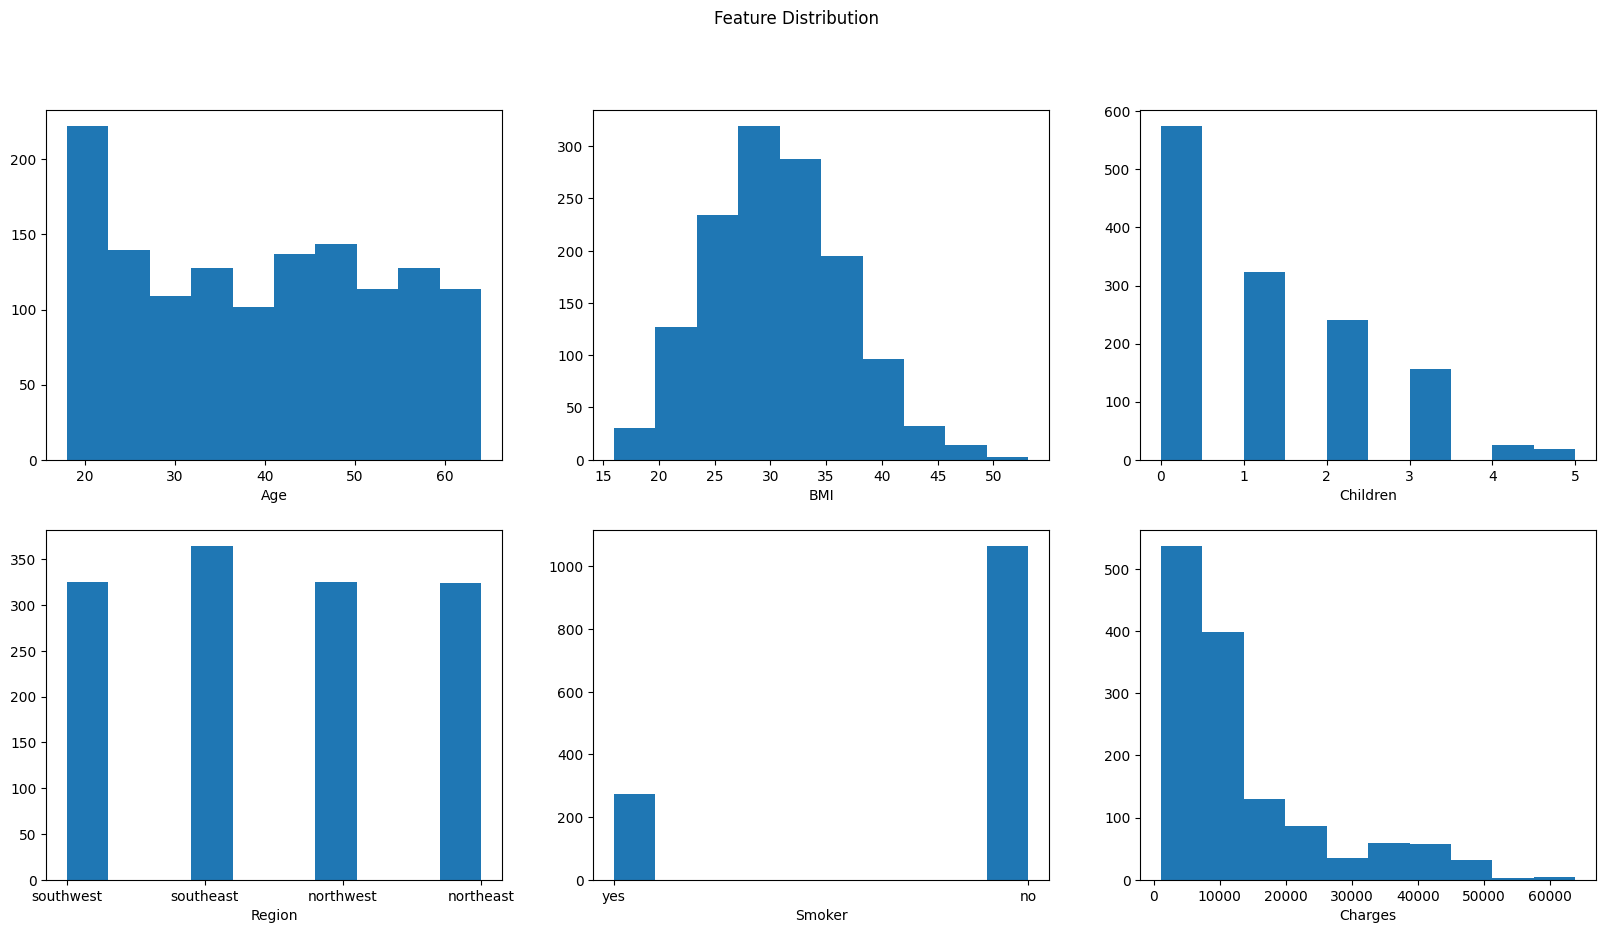

In [20]:
plt.figure(figsize=(20,10))
plt.suptitle("Feature Distribution")

plt.subplot(2,3,1)
plt.hist(df["age"])
plt.xlabel("Age")

plt.subplot(2,3,2)
plt.hist(df["bmi"])
plt.xlabel("BMI")

plt.subplot(2,3,3)
plt.hist(df["children"])
plt.xlabel("Children")

plt.subplot(2,3,4)
plt.hist(df["region"])
plt.xlabel("Region")

plt.subplot(2,3,5)
plt.hist(df["smoker"])
plt.xlabel("Smoker")

plt.subplot(2,3,6)
plt.hist(df["charges"])
plt.xlabel("Charges")

plt.show()

The target `Charge` is heavy negative skewed and feature like `Smoker` and `Children` are skewed. We need to perform a transformation to build a stable Linear Regression Model.

## PreProcessing

In [45]:
df_encoded = pd.get_dummies(
    df,
    columns=["region"],
    drop_first=True
)

df_encoded['sex'] = df['sex'].map({'male': 1, 'female': 0})
df_encoded['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})
df_encoded['region_northwest'] = df_encoded['region_northwest'].map({True: 1, False: 0})
df_encoded['region_southeast'] = df_encoded['region_southeast'].map({True: 1, False: 0})
df_encoded['region_southwest'] = df_encoded['region_southwest'].map({True: 1, False: 0})

df_encoded

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,1
1,18,1,33.770,1,0,1725.55230,0,1,0
2,28,1,33.000,3,0,4449.46200,0,1,0
3,33,1,22.705,0,0,21984.47061,1,0,0
4,32,1,28.880,0,0,3866.85520,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830,1,0,0
1334,18,0,31.920,0,0,2205.98080,0,0,0
1335,18,0,36.850,0,0,1629.83350,0,1,0
1336,21,0,25.800,0,0,2007.94500,0,0,1


>**NOTE:**
> When drop_first=True:
>- Pandas intentionally drops one category
>- The dropped category becomes the reference (baseline)
>- **WHY** it is done is -> This avoids multicollinearity in linear regression.

```region_NE + region_NW + region_SE + region_SW = 1```

In [46]:
# Log Transform the target
df_encoded["charges_log"] = np.log(df_encoded["charges"])

In [47]:
X = df_encoded.drop(columns=["charges", "charges_log"]).values
y = df_encoded["charges_log"].values.reshape(-1, 1)

**Note:** We should not Normalise/Standarised the dataset before splitting. Since we are not worried about the evaluation we are not splitting the data.

In [48]:
print(X.dtype)   # should be float64 or float32
print(X.shape)

float64
(1338, 8)


In [49]:
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

## Linear Regression


In [54]:
import numpy as np

m = np.zeros((X_norm.shape[1], 1))  # weights
b = 0
lr = 0.01
epochs = 3000
n = len(X_norm)

losses = []

for _ in range(epochs):
    y_pred = X_norm @ m + b
    error = y - y_pred

    dm = (-2/n) * X_norm.T @ error
    db = (-2/n) * np.sum(error)

    m -= lr * dm
    b -= lr * db

    loss = np.mean(error**2)
    losses.append(loss)

## Prediction

In [55]:
def predict_charges(input_row):
    x = (input_row - X_mean) / X_std
    log_charge = x @ m + b
    return np.exp(log_charge)

In [57]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = X_norm @ m + b
y_pred_actual = np.exp(y_pred)
y_actual = np.exp(y)

print("RMSE:", np.sqrt(mean_squared_error(y_actual, y_pred_actual)))
print("R2:", r2_score(y_actual, y_pred_actual))

RMSE: 8363.967450106065
R2: 0.5226243288541039
